In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from scipy.stats import spearmanr
from nltk.corpus import stopwords
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

eng_stopwords = set(stopwords.words("english"))

Using TensorFlow backend.


/kaggle/input/google-quest-challenge/sample_submission.csv
/kaggle/input/google-quest-challenge/train.csv
/kaggle/input/google-quest-challenge/test.csv


### Read the dataset
Let's first read the dataset in pandas dataframes. 

In [2]:
%%time
train_df = pd.read_csv('/kaggle/input/google-quest-challenge/train.csv')
sample_sub_df = pd.read_csv('/kaggle/input/google-quest-challenge/sample_submission.csv')
test_df = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')

CPU times: user 172 ms, sys: 52 ms, total: 224 ms
Wall time: 225 ms


### Glimpse of the dataset
Let's see the high level overview of given data, like observing first few records and size of given data.

In [3]:
pd.set_option('display.max_columns', None)
train_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [4]:
test_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [5]:
sample_sub_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [6]:
print (f'Sahpe of training set: {train_df.shape}')
print (f'Sahpe of testing set: {test_df.shape}')

Sahpe of training set: (6079, 41)
Sahpe of testing set: (476, 11)


In [7]:
train_df.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [8]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

In [9]:
total = len(train_df)

### Distribution of category variable

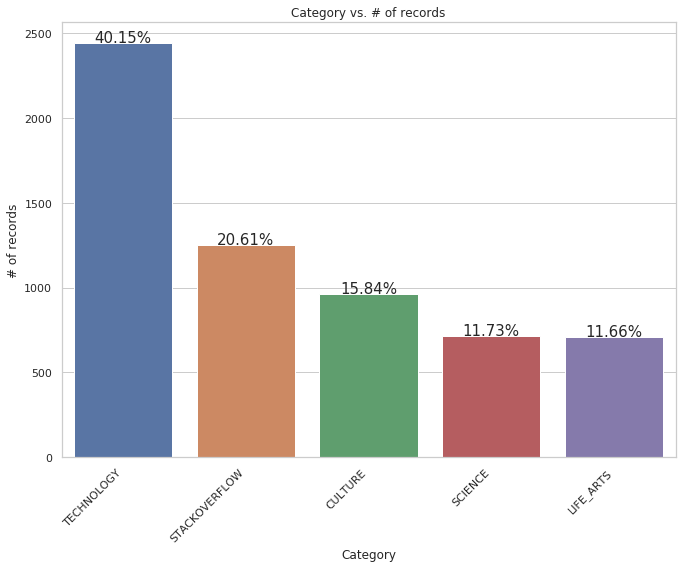

In [10]:
ax = sns.barplot(train_df['category'].value_counts().keys(), train_df['category'].value_counts())
ax.set(xlabel='Category', ylabel='# of records', title='Category vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for p in ax.patches: # loop to all objects and plot group wise % distribution
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

plt.show()

### Distribution of QA host platforms

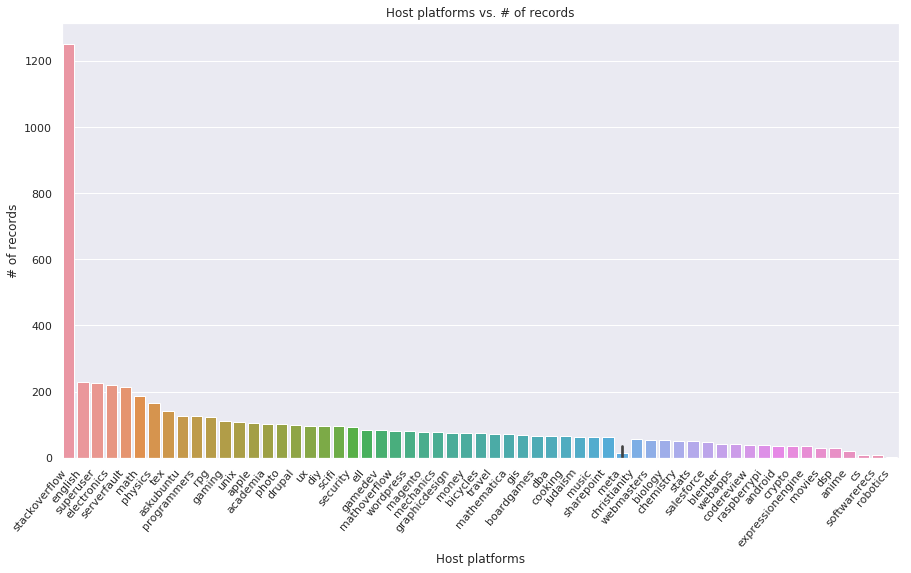

In [11]:
v = np.vectorize(lambda x: x.split('.')[0])
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(v(train_df['host'].value_counts().keys().values), train_df['host'].value_counts())
ax.set(xlabel='Host platforms', ylabel='# of records', title='Host platforms vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

It seems that most of the question answers from Stackoverflow (~20%) in training dataset.

### Visualizing Wordclouds of question and answer's raw (without preprocessing) text

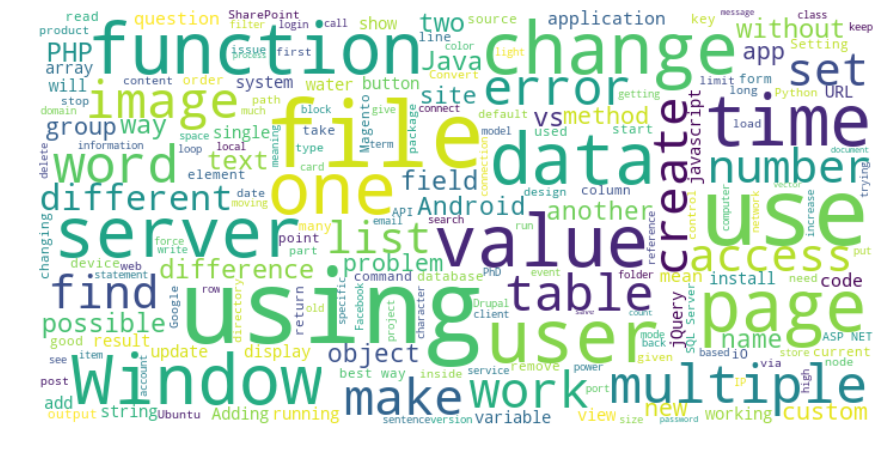

In [12]:
wc = WordCloud(background_color='white', max_font_size = 85, width=700, height=350)
wc.generate(','.join(train_df['question_title'].tolist()))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

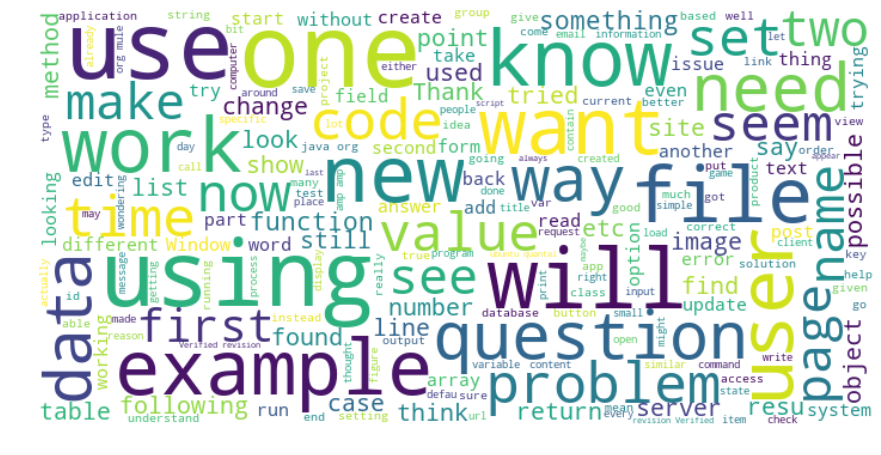

In [13]:
wc.generate(','.join(train_df['question_body'].tolist()).replace('gt', '').replace('lt', ''))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

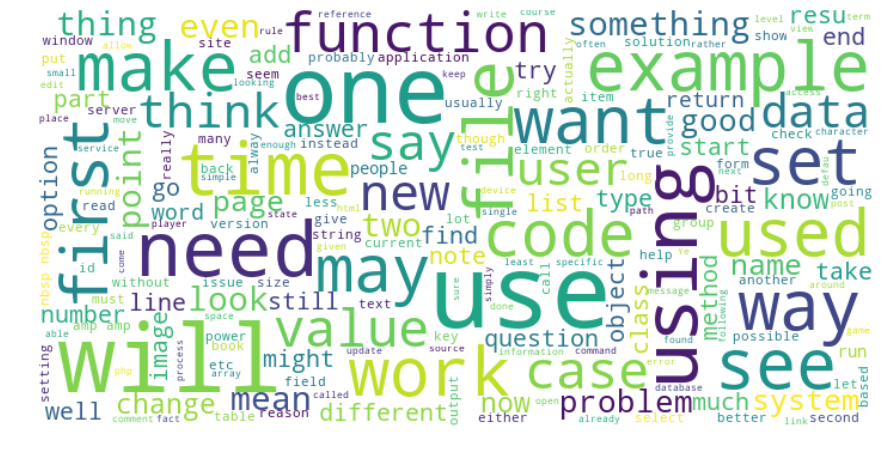

In [14]:
wc.generate(','.join(train_df['answer'].tolist()).replace('gt', '').replace('lt', ''))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

From the wordcloud highlighted words, it seems most of the words are technical and context of question and answer is technical (e.g. code, function, value, file, data, server, etc.).

In [15]:
target_cols = sample_sub_df.drop(['qa_id'], axis=1).columns.values
target_cols

array(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible',
       'answer_relevance', 'answer_satisfaction',
       'answer_type_instructions', 'answer_type_procedure',
       'answer_type_reason_explanation', 'answer_well_written'],
      dtype=object)

In [16]:
X_train = train_df.drop(np.concatenate([target_cols, np.array(['qa_id'])]), axis=1)
Y_train = train_df[target_cols]

In [17]:
print (f'Shape of X_train: {X_train.shape}')
print (f'Shape of Y_train: {Y_train.shape}')

Shape of X_train: (6079, 10)
Shape of Y_train: (6079, 30)


In [18]:
X_train.head()

,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com


In [19]:
X_test = test_df
del test_df
gc.collect()

41

### Feature Engineering:
Let's first extract meta features from the text.

We will start with creating meta featues. The feature list is as follows:

* Number of words in the text (size of question and answer)
* Number of unique words in the text
* Number of characters in the text
* Number of stopwords
* Number of punctuations
* Number of upper case words
* Number of title case words
* Average length of the words

In [20]:
%%time
# Size of answers
X_train['answer_size'] = X_train['answer'].apply(lambda x: len(str(x).split()))
X_test['answer_size'] = X_test['answer'].apply(lambda x: len(str(x).split()))

# Size of question body
X_train['question_body_size'] = X_train['question_body'].apply(lambda x: len(str(x).split()))
X_test['question_body_size'] = X_test['question_body'].apply(lambda x: len(str(x).split()))

# Size of question title
X_train['question_title_size'] = X_train['question_title'].apply(lambda x: len(str(x).split()))
X_test['question_title_size'] = X_test['question_title'].apply(lambda x: len(str(x).split()))

# Number of unique words in the answer
X_train['answer_num_unique_words'] = X_train['answer'].apply(lambda x: len(set(str(x).split())))
X_test['answer_num_unique_words'] = X_test['answer'].apply(lambda x: len(set(str(x).split())))

# Number of unique words in the question body
X_train['question_body_num_unique_words'] = X_train['question_body'].apply(lambda x: len(set(str(x).split())))
X_test['question_body_num_unique_words'] = X_test['question_body'].apply(lambda x: len(set(str(x).split())))

# Number of characters in the answer
X_train['answer_num_chars'] = X_train['answer'].apply(lambda x: len(str(x)))
X_test['answer_num_chars'] = X_test['answer'].apply(lambda x: len(str(x)))

# Number of characters in the question body
X_train['question_body_num_chars'] = X_train['question_body'].apply(lambda x: len(str(x)))
X_test['question_body_num_chars'] = X_test['question_body'].apply(lambda x: len(str(x)))

# Number of stopwords in the answer
X_train['answer_num_stopwords'] = X_train['answer'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
X_test['answer_num_stopwords'] = X_test['answer'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of stopwords in the question body
X_train['question_body_num_stopwords'] = X_train['question_body'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
X_test['question_body_num_stopwords'] = X_test['question_body'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of punctuations in the answer
X_train['answer_num_punctuations'] = X_train['answer'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
X_test['answer_num_punctuations'] = X_test['answer'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of punctuations in the question body
X_train['question_body_num_punctuations'] = X_train['question_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
X_test['question_body_num_punctuations'] = X_test['question_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# # Average length of the words in the answer
# X_train['answer_mean_word_len'] = X_train['answer'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# X_test['answer_mean_word_len'] = X_test['answer'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# # Average length of the words in the question body
# X_train['question_body_mean_word_len'] = X_train['question_body'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# X_test['question_body_mean_word_len'] = X_test['question_body'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Number of upper case words in the answer
X_train['answer_num_words_upper'] = X_train['answer'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
X_test['answer_num_words_upper'] = X_test['answer'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of upper case words in the question body
X_train['question_body_num_words_upper'] = X_train['question_body'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
X_test['question_body_num_words_upper'] = X_test['question_body'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the answer
X_train['answer_num_words_title'] = X_train['answer'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
X_test['answer_num_words_title'] = X_test['answer'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of title case words in the question body
X_train['question_body_num_words_title'] = X_train['question_body'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
X_test['question_body_num_words_title'] = X_test['question_body'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

CPU times: user 2.83 s, sys: 0 ns, total: 2.83 s
Wall time: 2.83 s


In [21]:
X_train.head()

,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,answer_size,question_body_size,question_title_size,answer_num_unique_words,question_body_num_unique_words,answer_num_chars,question_body_num_chars,answer_num_stopwords,question_body_num_stopwords,answer_num_punctuations,question_body_num_punctuations,answer_num_words_upper,question_body_num_words_upper,answer_num_words_title,question_body_num_words_title
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,150,141,13,102,107,833,836,70,53,30,34,8,8,11,15
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,74,142,16,61,102,451,789,27,60,14,30,2,3,5,12
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,183,118,7,118,79,1048,653,81,53,23,20,4,6,11,8
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,248,75,8,175,52,1337,425,70,36,40,11,0,0,21,6
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,27,81,9,24,52,225,416,5,40,27,14,3,6,7,10


In [22]:
X_train = X_train.drop(['question_user_name', 'question_user_page', 'answer_user_name', 'answer_user_page', 'url'], axis=1)
X_test = X_test.drop(['question_user_name', 'question_user_page', 'answer_user_name', 'answer_user_page', 'url', 'qa_id'], axis=1)

In [23]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tsvd = TruncatedSVD(n_components = 1000)

question_title = tfv.fit_transform(X_train['question_title'].values).toarray()
question_title_test = tfv.transform(X_test['question_title'].values).toarray()
#question_title = tfv.fit_transform(X_train['question_title'].values)
#question_title_test = tfv.transform(X_test['question_title'].values)
#question_title = tsvd.fit_transform(question_title)
#question_title_test = tsvd.transform(question_title_test)

question_body = tfv.fit_transform(X_train['question_body'].values).toarray()
question_body_test = tfv.transform(X_test['question_body'].values).toarray()
#question_body = tfv.fit_transform(X_train['question_body'].values)
#question_body_test = tfv.transform(X_test['question_body'].values)
#question_body = tsvd.fit_transform(question_body)
#question_body_test = tsvd.transform(question_body_test)

answer = tfv.fit_transform(X_train['answer'].values).toarray()
answer_test = tfv.transform(X_test['answer'].values).toarray()
#answer = tfv.fit_transform(X_train['answer'].values)
#answer_test = tfv.transform(X_test['answer'].values)
#answer = tsvd.fit_transform(answer)
#answer_test = tsvd.transform(answer_test)

In [24]:
cat_le = LabelEncoder()
cat_le.fit(X_train['category'])
category = cat_le.transform(X_train['category'])
category_test = cat_le.transform(X_test['category'])

In [25]:
host_le = LabelEncoder()
host_le.fit(pd.concat([X_train['host'], X_test['host']], ignore_index=True))
host = host_le.transform(X_train['host'])
host_test = host_le.transform(X_test['host'])

In [26]:
meta_features_train = X_train.drop(['question_title', 'question_body', 'answer', 'category', 'host'], axis=1).to_numpy()
meta_features_test = X_test.drop(['question_title', 'question_body', 'answer', 'category', 'host'], axis=1).to_numpy()

In [27]:
X_train = np.concatenate([question_title, question_body, answer], axis=1)
X_test = np.concatenate([question_title_test, question_body_test, answer_test], axis=1)

In [28]:
del question_title
del question_title_test
del answer
del answer_test
del question_body
del question_body_test
gc.collect()

0

In [29]:
X_train = np.column_stack((X_train, category, host, meta_features_train))
X_test = np.column_stack((X_test, category_test, host_test, meta_features_test))

In [30]:
del category
del host
del meta_features_train
del category_test
del host_test
del meta_features_test
gc.collect()

0

In [31]:
print (X_train.shape)
print (X_test.shape)

(6079, 108235)
(476, 108235)


In [32]:
np.isnan(X_train).any()

False

In [33]:
len(X_test)

476

In [34]:
folds = 5
seed = 666

kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
test_preds = np.zeros((len(X_test), len(target_cols)))
fold_scores = []

for train_index, val_index in kf.split(X_train):
    x_train, y_train = X_train[train_index, :], Y_train.iloc[train_index]
    x_val, y_val = X_train[val_index, :], Y_train.iloc[val_index]
    
    model = Sequential([
        Dense(256, input_shape=(X_train.shape[1],)),
        Dropout(0.25),
        Activation('relu'),
        Dense(128),
        Dropout(0.20),
        Activation ('relu'),
        Dense(len(target_cols)),
        Activation('sigmoid'),
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    
    preds = model.predict(x_val)
    overall_score = 0
    
    for col_index, col in enumerate(target_cols):
        overall_score += spearmanr(preds[:, col_index], y_val[col].values).correlation/len(target_cols)
        
    fold_scores.append(overall_score)
#     models.append(model)
    test_preds += model.predict(X_test)/folds
    del x_train
    del y_train
    del x_val
    del y_val
    gc.collect()

print(fold_scores)

Train on 4863 samples, validate on 1216 samples
Epoch 1/20
4863/4863 [==============================] - 63s 13ms/step - loss: 0.5272 - val_loss: 0.4311
Epoch 2/20
4863/4863 [==============================] - 63s 13ms/step - loss: 0.4407 - val_loss: 0.4229
Epoch 3/20
4863/4863 [==============================] - 64s 13ms/step - loss: 0.4308 - val_loss: 0.4191
Epoch 4/20
4863/4863 [==============================] - 64s 13ms/step - loss: 0.4254 - val_loss: 0.4137
Epoch 5/20
4863/4863 [==============================] - 64s 13ms/step - loss: 0.4204 - val_loss: 0.4134
Epoch 6/20
4863/4863 [==============================] - 64s 13ms/step - loss: 0.4164 - val_loss: 0.4130
Epoch 7/20
4863/4863 [==============================] - 65s 13ms/step - loss: 0.4127 - val_loss: 0.4074
Epoch 8/20
4863/4863 [==============================] - 65s 13ms/step - loss: 0.4114 - val_loss: 0.4091
Epoch 9/20
4863/4863 [==============================] - 64s 13ms/step - loss: 0.4093 - val_loss: 0.4054
Epoch 10/20
4863

In [35]:
for col_index, col in enumerate(target_cols):
    sample_sub_df[col] = test_preds[:, col_index]

In [36]:
sample_sub_df.to_csv("submission.csv", index = False)